In [1]:
import pandas as pd

# Load the data from the file into a DataFrame
file_path = 'data/20240102180106.txt'
df = pd.read_csv(file_path, sep='\t')  # Assuming the separator is a tab, as common in such data logs

In [3]:
data = pd.DataFrame()
data[['acc_X(g)', 'acc_Y(g)', 'acc_Z(g)', 'Time']] = df[['加速度X(g)', '加速度Y(g)', '加速度Z(g)', '时间']]

In [4]:
data

,acc_X(g),acc_Y(g),acc_Z(g),Time
0,-0.388,0.784,0.486,2024-1-2 18:1:7:17
1,-0.388,0.783,0.485,2024-1-2 18:1:7:138
2,-0.388,0.784,0.486,2024-1-2 18:1:7:225
3,-0.388,0.784,0.486,2024-1-2 18:1:7:343
4,-0.387,0.783,0.486,2024-1-2 18:1:7:435
...,...,...,...,...
4635,0.564,0.808,0.180,2024-1-2 18:39:16:948
4636,0.573,0.821,0.183,2024-1-2 18:39:17:12
4637,0.573,0.808,0.177,2024-1-2 18:39:17:162
4638,0.563,0.806,0.174,2024-1-2 18:39:17:251


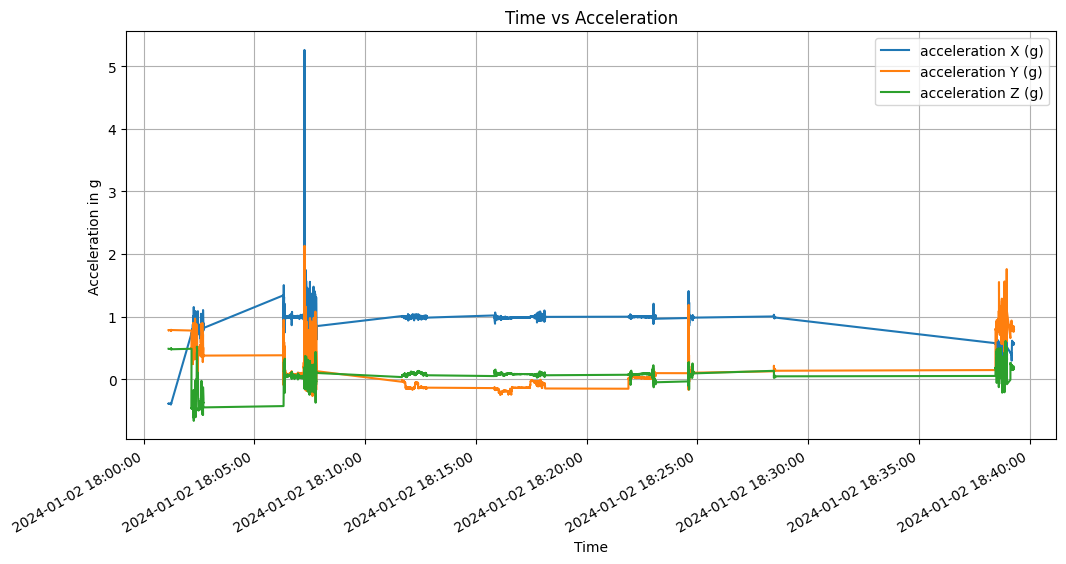

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Adjusting the datetime parsing to accommodate the specific format of the timestamps
# The format seems to be 'year-month-day hour:minute:second:millisecond'
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d %H:%M:%S:%f')

# Re-plotting
plt.figure(figsize=(12, 6))

# Plotting each acceleration component
plt.plot(data['Time'], data['acc_X(g)'], label='acceleration X (g)')
plt.plot(data['Time'], data['acc_Y(g)'], label='acceleration Y (g)')
plt.plot(data['Time'], data['acc_Z(g)'], label='acceleration Z (g)')

# Formatting the plot
plt.xlabel('Time')
plt.ylabel('Acceleration in g')
plt.title('Time vs Acceleration')
plt.legend()
plt.grid(True)

# Improve date formatting on x-axis
plt.gcf().autofmt_xdate() # Auto format for better date representation
myFmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)

# Show the plot
plt.show()



这段代码将会生成一个散点图矩阵，显示了 x，y 和 z 这三个特征之间的关系，不同的颜色表示不同的聚类。由于数据集可能很大，所以我们随机抽取了一部分数据进行可视化。如果你希望可视化更多的数据，可以调整 min(5000, len(data_clustered)) 这一行中的 5000 这个数字。

### K-means

In [18]:
import pandas as pd
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler

# 假设 df 是包含您数据的 pandas DataFrame
# 加载数据


# 选择加速度数据
acceleration_data = data[['加速度X(g)', '加速度Y(g)', '加速度Z(g)']]

# 数据预处理：标准化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(acceleration_data)

# 时间序列数据通常需要特定的预处理
# 这里我们使用 TimeSeriesScalerMeanVariance 将时间序列标准化为平均值为0，方差为1
scaled_data = TimeSeriesScalerMeanVariance().fit_transform(scaled_data.reshape(scaled_data.shape[0], scaled_data.shape[1], 1))

# 使用 K-均值聚类
n_clusters = 3  # 假设我们希望将数据分成3类
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=10)

# 训练模型
model.fit(scaled_data)

# 预测聚类标签
labels = model.predict(scaled_data)

# 将聚类结果添加到原始 DataFrame
data['Cluster'] = labels

# 现在 df 包含了每个时间点数据的聚类标签


/tmp/ipykernel_1019/2731827514.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = labels


KeyError: 'acc X(g)'

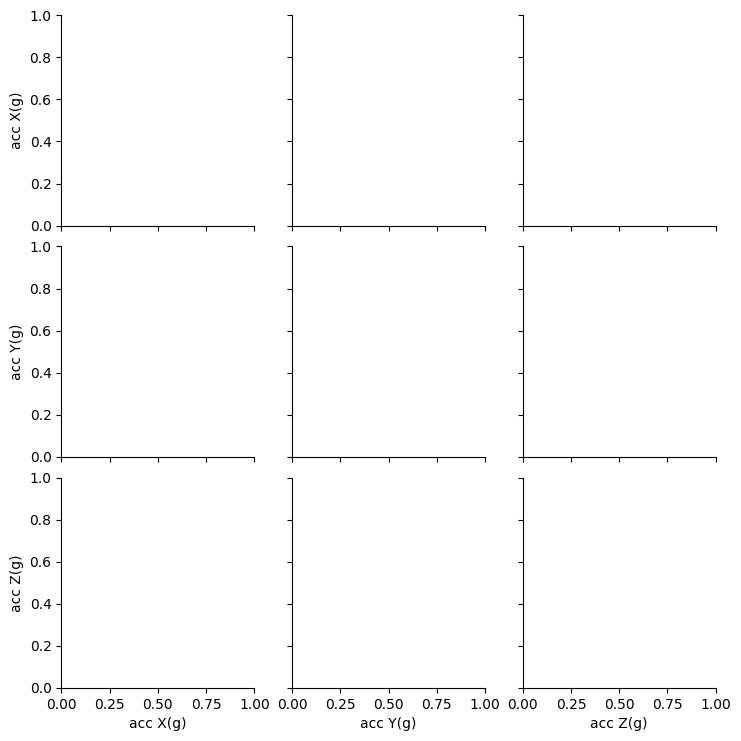

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the clustered data
data_clustered = data

# Due to the potential large size of the dataset, we randomly sample a subset for visualization
data_sample = data_clustered.sample(n=min(5000, len(data_clustered)), random_state=1)

# Create a pairplot colored by the cluster assignment
sns.pairplot(data_sample, vars=['加速度X(g)', '加速度Y(g)', '加速度Z(g)'], hue='Cluster', plot_kws={'alpha': 0.5})
plt.show()

In [20]:
data.head()

,加速度X(g),加速度Y(g),加速度Z(g),时间,Cluster
0,-0.388,0.784,0.486,2024-01-02 18:01:07.170,0
1,-0.388,0.783,0.485,2024-01-02 18:01:07.138,0
2,-0.388,0.784,0.486,2024-01-02 18:01:07.225,0
3,-0.388,0.784,0.486,2024-01-02 18:01:07.343,0
4,-0.387,0.783,0.486,2024-01-02 18:01:07.435,0
...,...,...,...,...,...
95,0.771,0.514,-0.435,2024-01-02 18:02:11.680,2
96,0.761,0.512,-0.424,2024-01-02 18:02:11.184,2
97,0.775,0.489,-0.418,2024-01-02 18:02:11.278,2
98,0.785,0.470,-0.391,2024-01-02 18:02:11.395,2


In [21]:
data.to_csv('data/20240102180106_clustered.txt', sep='\t', index=False)

In [22]:
scaled_data

array([[[-1.40900063],
        [ 0.59943877],
        [ 0.80956185]],

       [[-1.40904524],
        [ 0.59991081],
        [ 0.80913443]],

       [[-1.40900063],
        [ 0.59943877],
        [ 0.80956185]],

       ...,

       [[-1.29446677],
        [ 1.14045427],
        [ 0.1540125 ]],

       [[-1.29431497],
        [ 1.14067705],
        [ 0.15363792]],

       [[-1.29812903],
        [ 1.13501284],
        [ 0.16311619]]])

/tmp/ipykernel_1019/219380001.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(clusters))
/tmp/ipykernel_1019/219380001.py:25: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1019/219380001.py:25: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1019/219380001.py:25: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1019/219380001.py:25: UserWarning: Glyph 36895 (\N{CJK UNIFIED IDEOGRAPH-901F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1019/219380001.py:25: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.


'data/modified_acceleration_time_series_plot.png'

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36895 (\N{CJK UNIFIED IDEOGRAPH-901F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from c

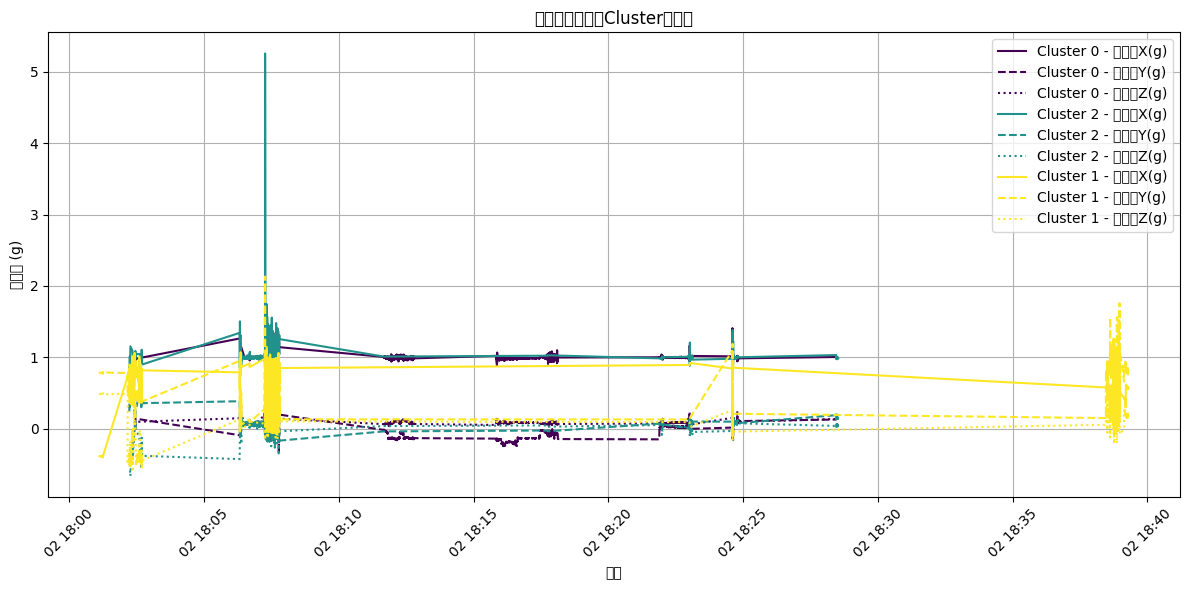

In [29]:
# To modify the plot by adding annotations based on the 'Cluster' column and using different colors, 
# we need to plot each cluster separately.

# Getting unique clusters
clusters = data['Cluster'].unique()

# Creating a color map for different clusters
colors = plt.cm.get_cmap('viridis', len(clusters))

plt.figure(figsize=(12, 6))

# Plotting each cluster with a different color
for i, cluster in enumerate(clusters):
    cluster_df = df[df['Cluster'] == cluster]
    plt.plot(cluster_df['时间'], cluster_df['加速度X(g)'], label=f'Cluster {cluster} - 加速度X(g)', color=colors(i))
    plt.plot(cluster_df['时间'], cluster_df['加速度Y(g)'], label=f'Cluster {cluster} - 加速度Y(g)', color=colors(i), linestyle='--')
    plt.plot(cluster_df['时间'], cluster_df['加速度Z(g)'], label=f'Cluster {cluster} - 加速度Z(g)', color=colors(i), linestyle=':')

plt.xlabel('时间')
plt.ylabel('加速度 (g)')
plt.title('加速度随时间和Cluster的变化')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the modified plot to a file
modified_plot_path = 'data/modified_acceleration_time_series_plot.png'
plt.savefig(modified_plot_path)

modified_plot_path


In [28]:
for i, k in enumerate(clusters):
    print(i, k)

0 0
1 2
2 1
